In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!nvidia-smi
!pip install -U git+https://github.com/qubvel/efficientnet

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from glob import glob
import os, zipfile, cv2

import tensorflow.keras.layers as L
import tensorflow.keras as K
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

In [0]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
NUM_EPOCHS = 20
STEPS = 128
NUM_CLASSES = 20
DATASET_PATH = '/content/datasets/'

if not os.path.exists(DATASET_PATH):
    f = zipfile.ZipFile("/content/drive/My Drive/Colab Notebooks/catus_06.zip")
    f.extractall("./")

In [5]:
import efficientnet.tfkeras as efn

net = efn.EfficientNetB5(input_shape= (IMAGE_SIZE, IMAGE_SIZE, 3),
                         weights= 'noisy-student',
                         include_top= False)

for layer in net.layers:
    layer.trainable = True

x = net.output
# BN-Relu
x = L.BatchNormalization()(x)
x = L.Activation('relu')(x)
x = L.GlobalMaxPooling2D()(x)
out = L.Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=net.input, outputs=out)

model.compile(loss= K.losses.CategoricalCrossentropy(), 
              optimizer= K.optimizers.Adam(amsgrad=True), 
              metrics= [K.metrics.CategoricalAccuracy()])

115261440/115255328 [==============================] - 3s 0us/step


In [6]:
trn_dagen = ImageDataGenerator(rescale= 1./255)

trn_gen = trn_dagen.flow_from_directory(DATASET_PATH + 'train',
                                        target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                        batch_size=BATCH_SIZE,
                                        class_mode='categorical',
                                        shuffle=True)

val_eva_dagen = ImageDataGenerator(rescale= 1./255,
                                   validation_split=0.5)

val_gen = val_eva_dagen.flow_from_directory(DATASET_PATH + 'test',
                                            target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                            batch_size= BATCH_SIZE,
                                            class_mode='categorical',
                                            shuffle=True,
                                            subset='training')
                                            
eva_gen = val_eva_dagen.flow_from_directory(DATASET_PATH + 'test',
                                            target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                            batch_size= BATCH_SIZE * 10,
                                            class_mode='categorical',
                                            shuffle=True,
                                            subset='validation')

Found 6480 images belonging to 20 classes.
Found 1085 images belonging to 20 classes.
Found 1078 images belonging to 20 classes.


In [20]:
STEP_SIZE_TRAIN = trn_gen.n // BATCH_SIZE
STEP_SIZE_VALID = val_gen.n // BATCH_SIZE

history = model.fit(trn_gen,
                    steps_per_epoch= STEP_SIZE_TRAIN,
                    epochs= NUM_EPOCHS,
                    verbose= 1,
                    validation_data= val_gen,
                    validation_steps= STEP_SIZE_VALID)

Epoch 1/20
202/202 [==============================] - 135s 668ms/step - loss: 0.1107 - categorical_accuracy: 0.9625 - val_loss: 0.0170 - val_categorical_accuracy: 0.9962
Epoch 2/20
202/202 [==============================] - 135s 666ms/step - loss: 0.0690 - categorical_accuracy: 0.9766 - val_loss: 0.0131 - val_categorical_accuracy: 0.9972
Epoch 3/20
202/202 [==============================] - 135s 668ms/step - loss: 0.0566 - categorical_accuracy: 0.9829 - val_loss: 0.0142 - val_categorical_accuracy: 0.9981
Epoch 4/20
202/202 [==============================] - 135s 669ms/step - loss: 0.0458 - categorical_accuracy: 0.9859 - val_loss: 0.0120 - val_categorical_accuracy: 0.9972
Epoch 5/20
202/202 [==============================] - 135s 669ms/step - loss: 0.0420 - categorical_accuracy: 0.9901 - val_loss: 0.0110 - val_categorical_accuracy: 0.9962
Epoch 6/20
202/202 [==============================] - 135s 670ms/step - loss: 0.0477 - categorical_accuracy: 0.9870 - val_loss: 0.0171 - val_categoric

In [21]:
loss, acc = model.evaluate(eva_gen, steps= len(eva_gen))
print('評估的準確率::  ', acc)

4/4 [==============================] - 4s 875ms/step - loss: 0.4658 - categorical_accuracy: 0.8850
評估的準確率::   0.8849721550941467


In [0]:
model.save('/content/drive/My Drive/catus_02.h5')

In [37]:
# 從 HDF5 檔案中載入模型
model = tf.keras.models.load_model('/content/drive/My Drive/catus_02.h5')

loss, acc = model.evaluate(eva_gen, steps= len(eva_gen))
print('評估的準確率::  ', acc)

4/4 [==============================] - 4s 880ms/step - loss: 0.4658 - categorical_accuracy: 0.8850
評估的準確率::   0.8849721550941467


Text(0.5, 1.0, 'InceptionResNetV2 - acc')

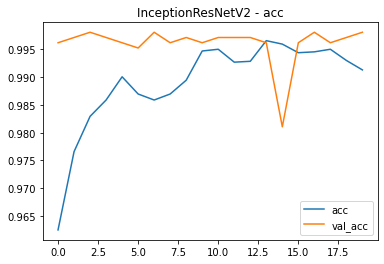

In [22]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.legend(['acc', 'val_acc'])
plt.title('InceptionResNetV2 - acc')

Text(0.5, 1.0, 'InceptionResNetV2 - loss')

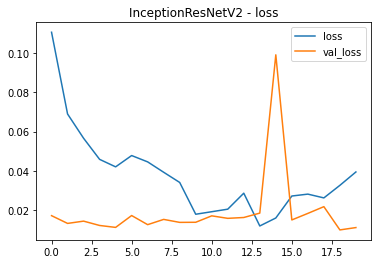

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('InceptionResNetV2 - loss')

In [24]:
import pandas as pd
from sklearn.metrics import confusion_matrix

train, label = eva_gen.next()

pre = model.predict(train, steps= 1)
pre = pre.argmax(axis= -1)
label = label.argmax(axis= -1)

df = pd.DataFrame(confusion_matrix(label, pre))
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,16,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
2,0,1,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,20,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
4,0,0,0,0,17,1,0,0,0,0,0,0,0,1,0,2,0,0,0,0
5,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,1
9,0,0,0,0,0,0,0,0,0,7,0,0,0,3,0,0,0,0,0,0


In [0]:
if not os.path.exists('simhei.zip'):
    !wget "https://www.wfonts.com/download/data/2014/06/01/simhei/simhei.zip"
    !unzip "simhei.zip"
    !mv SimHei.ttf /usr/share/fonts/truetype/

import matplotlib.font_manager as fm

path = '/usr/share/fonts/truetype/SimHei.ttf'
fontprop = fm.FontProperties(fname=path, size=13)

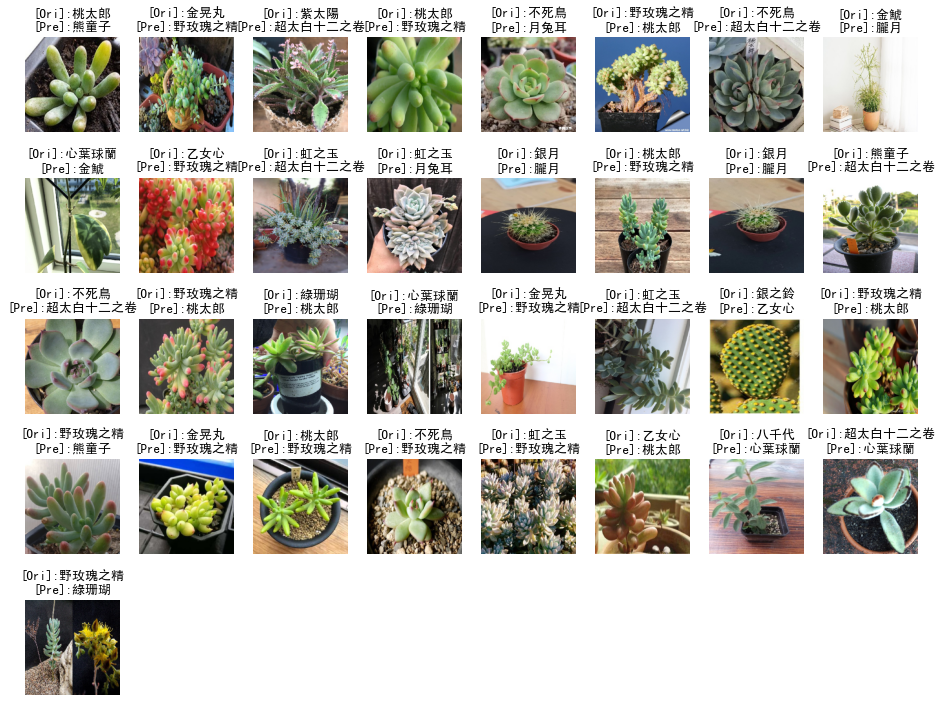

In [27]:
trans = {
    0: '熊童子', 1: '心葉球蘭', 2: '八千代', 3: '乙女心', 4: '不死鳥', 
    5: '月兔耳', 6: '火祭', 7: '白鳥帽子', 8: '金鯱', 9: '金晃丸', 
    10: '紅蘋果椒草', 11: '虹之玉', 12: '桃太郎', 13: '野玫瑰之精', 14: '紫太陽', 
    15: '超太白十二之卷', 16: '綠珊瑚', 17: '銀之鈴', 18: '銀月', 19: '朧月'
}

idx = np.nonzero(pre != label)[0]
# 預測錯誤的圖
false_img = train[idx]
false_answer = label[idx]
false_predict = pre[idx]

# 把圖變大一點才塞的下

width = 8
height = len(false_img) // width + 1
plt.figure(figsize=(width * 2, height * 2.5))
for i, img in enumerate(false_img):
    plt.subplot(height, width, i+1)
    plt.axis("off")
    t = "[Ori]:{}\n[Pre]:{}".format(trans[false_answer[i]],
                                    trans[false_predict[i]])
    plt.title(t, fontproperties=fontprop)
    plt.imshow(img)

In [28]:
from tensorflow.keras.preprocessing.image import load_img
from glob import glob

scan_img_list = sorted(glob('/content/scan/*'))

isTrue = 0
img_false_index = []
pre_ans_name = []
for i, fn in enumerate(scan_img_list):
    img = load_img(fn, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    img_norm = np.array(img).reshape(1, IMAGE_SIZE, IMAGE_SIZE, 3) / 255
    ans = model.predict(img_norm)[0]
    ans = ans.argmax(axis= -1)
    
    img_name = fn.split('/')[-1]
    img_type = img_name.split('_')[0]
    img_flag = trans[ans] == trans[int(img_type)]

    img_false_index.append(img_flag)
    pre_ans_name.append(trans[ans] + '_' + trans[int(img_type)])
    
    if img_flag:
        isTrue += 1
        
    print(img_name, ' 分析為:', trans[ans], '\t', img_flag, '\t 答案為: ', trans[int(img_type)], '\t  正確率: {:.3f}'.format(isTrue / (i + 1)))

00_01.jpg  分析為: 熊童子 	 True 	 答案為:  熊童子 	  正確率: 1.000
00_02.jpg  分析為: 熊童子 	 True 	 答案為:  熊童子 	  正確率: 1.000
00_03.jpg  分析為: 紅蘋果椒草 	 False 	 答案為:  熊童子 	  正確率: 0.667
00_04.jpg  分析為: 熊童子 	 True 	 答案為:  熊童子 	  正確率: 0.750
00_05.jpg  分析為: 熊童子 	 True 	 答案為:  熊童子 	  正確率: 0.800
00_06.jpg  分析為: 熊童子 	 True 	 答案為:  熊童子 	  正確率: 0.833
00_07.jpg  分析為: 熊童子 	 True 	 答案為:  熊童子 	  正確率: 0.857
00_08.jpg  分析為: 熊童子 	 True 	 答案為:  熊童子 	  正確率: 0.875
00_09.jpg  分析為: 桃太郎 	 False 	 答案為:  熊童子 	  正確率: 0.778
00_10.jpg  分析為: 熊童子 	 True 	 答案為:  熊童子 	  正確率: 0.800
00_11.jpg  分析為: 熊童子 	 True 	 答案為:  熊童子 	  正確率: 0.818
00_12.jpg  分析為: 熊童子 	 True 	 答案為:  熊童子 	  正確率: 0.833
00_13.jpg  分析為: 超太白十二之卷 	 False 	 答案為:  熊童子 	  正確率: 0.769
00_14.JPG  分析為: 熊童子 	 True 	 答案為:  熊童子 	  正確率: 0.786
00_15.JPG  分析為: 熊童子 	 True 	 答案為:  熊童子 	  正確率: 0.800
01_01.jpg  分析為: 心葉球蘭 	 True 	 答案為:  心葉球蘭 	  正確率: 0.812
01_02.jpg  分析為: 心葉球蘭 	 True 	 答案為:  心葉球蘭 	  正確率: 0.824
01_03.jpg  分析為: 心葉球蘭 	 True 	 答案為:  心葉球蘭 	  正確率: 0.833
01_05.jpg  分析為: 心葉球蘭 	 True 	 答

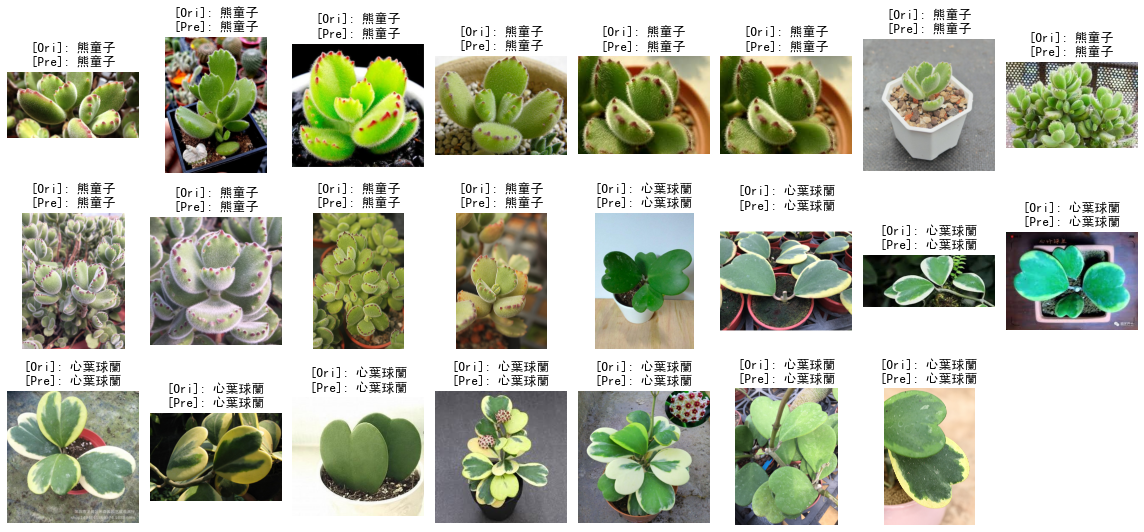

In [29]:
import numpy as np
from glob import glob
import cv2

np_img_false = np.array(img_false_index)
np_img_paths = np.array(scan_img_list)
np_pre_ans_name = np.array(pre_ans_name)

image_paths = np_img_paths[np_img_false]
image_pre_ans_false = np_pre_ans_name[np_img_false]

# 設定 plt 方式
width = 8
height = len(image_paths) // width + 1
plt.figure(figsize=(width * 2, height * 2.5))
# 依序 讀取圖片、顯示
for i in range(len(image_paths)):
    img = cv2.imread(image_paths[i])[:, :, ::-1]
    plt.subplot(height, width, i+1)
    plt.axis("off")
    plt.tight_layout()

    pre_img, ori_img = image_pre_ans_false[i].split('_')
    t = f"[Ori]: {ori_img}\n[Pre]: {pre_img}"
    plt.title(t, fontproperties=fontprop)
    
    plt.imshow(img, cmap="gray")

In [30]:
image_paths = np_img_paths[np_img_false == False]
image_pre_ans_false = np_pre_ans_name[np_img_false == False]

# 設定 plt 方式
width = 8
height = len(image_paths) // width + 1
plt.figure(figsize=(width * 2, height * 2.5))
# 依序 讀取圖片、顯示
for i in range(len(image_paths)):
    img = cv2.imread(image_paths[i])[:, :, ::-1]
    plt.subplot(height, width, i+1)
    plt.axis("off")
    # plt.tight_layout()

    pre_img, ori_img = image_pre_ans_false[i].split('_')
    t = f"[Ori]: {ori_img}\n[Pre]: {pre_img}"
    plt.title(t, fontproperties=fontprop)
    
    plt.imshow(img, cmap="gray")

Output hidden; open in https://colab.research.google.com to view.